# Myntra Fasion Data - Semantic Spotter Assignment

### Objective:
- Create a generative search engine capable of searching a plethora of product descriptions to find and recommend appropriate choices against user query.

#### Why Llama-index or Lang-chain is used?
- The biggest disadvantage of Openai LLM models is it does not have domain specific knowledge.  
- To overcome this drawback, Llama-Index or Lang-chain is very helpful.  
- We can store the documents in the form of vectors using Llama-Index or Lang-chain, and retrieval of the the document is also easy.

In [1]:
# %pip install llama-index -q
# %pip install openai -q

## Importing libraries

In [2]:
# from llama_index.llms.openai import OpenAI
# from llama_index.core.llms import ChatMessage
from llama_index.core import Document, VectorStoreIndex
# from llama_index.core.node_parser import SimpleNodeParser
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import requests
from io import BytesIO

from openai import OpenAI 
import openai
import textwrap
import re
import os

## Set API Key

In [3]:
with open('openai_api_key.txt') as file:
    api_key = ' '.join(file.readlines())

client = OpenAI(api_key=api_key)

## Load the data

In [4]:
df = pd.read_csv('Fashion Dataset v2.csv')
updated_df = df[['p_id', 'products', 'price', 'colour', 'brand', 'description']]
updated_df.head(2)

,p_id,products,price,colour,brand,description
0,17048614,"Kurta, Palazzos, Dupatta",5099.0,Black,Khushal K,Black printed Kurta with Palazzos with dupatta...
1,16524740,"Kurta, Palazzos, Floral Print Dupatta",5899.0,Orange,InWeave,Orange solid Kurta with Palazzos with dupatta<...


In [5]:
documents = []
for row_id, row in updated_df.iterrows():
    row_str = ' | '.join(f"{col} : {val}" for col, val in row.items())
    
    # Remove URLs
    clean_row = re.sub(r'https?://\S+', '', row_str)
    # Remove HTML tags
    clean_row = re.sub(r'<.*?>', '', clean_row)
    
    clean_row = f'Row {row_id} : ' + clean_row
     
    doc = Document(text=clean_row) 
    documents.append(doc)

## Building the query engine

In [8]:
openai.api_key = api_key
# Build the index
index = VectorStoreIndex.from_documents(documents)

# Construct query engine
query_engine = index.as_query_engine()

In [9]:
def market_the_product(response):
    # Extracting the row number from the response
    text = response.source_nodes[0].node.text[4:10]
    row_number = int(''.join([char for char in text if char.isdigit()]))

    # Extracting product description from the data set
    description = df.iloc[row_number, 9]

    # Market the product using openai llm
    llm_response = client.chat.completions.create(
                        model = 'gpt-3.5-turbo',
                        messages=[
                            {'role' : 'system', 'content' : 'You are a marketing expert who creates compelling marketing statements'},
                            {'role' : 'user', 'content' : f'Create an attractive and short marketing statement for the product : {description}'}
                        ],
                        max_tokens= 200,
                        temperature=0.5,
                        n=1,
    )

    # Response from LLM
    marketing_statement = llm_response.choices[0].message.content
    marketing_statement = textwrap.fill(marketing_statement, width=70)

    return marketing_statement

In [10]:
def extract_image_from_url(response):
    # Extracting the row number from the response
    text = response.source_nodes[0].node.text[4:10]
    row_number = int(''.join([char for char in text if char.isdigit()]))

    # URL of the image
    url = df.iloc[row_number, 6]

    # Fetch the image from the url
    image_response = requests.get(url=url)
    img = mpimg.imread(BytesIO(image_response.content), format='jpg')

    return img

In [11]:
def display_output(query, marketing_statement, img):
    # Display the text output
    print("\n\nUser Query : ")
    print('\t', query)
    print('\n Response :')
    print('\t', marketing_statement)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("*" * 80)
    return None

## User Query



User Query : 
	 give me a red jumpsuit with polka dots

 Response :
	 "Step into style with our Red and White Polka Dot Jumpsuit! Perfect
for any occasion, this trendy piece features a flattering v-neck,
playful polka dot print, and convenient tie-up closures. Made from
high-quality polyester, it's easy to care for and comfortable to wear.
Elevate your wardrobe with this must-have jumpsuit today!"


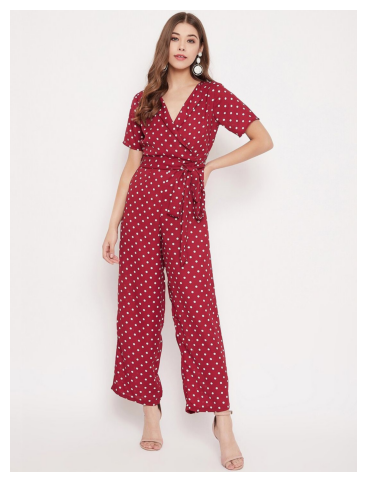

********************************************************************************


User Query : 
	 I need traditional wear outfit for diwali. I am interested in a beautiful green color saree 

 Response :
	 "Elevate your festive look with our exquisite Green Woven Saree!
Embrace elegance with its charming floral print and woven design
border. Crafted from luxurious silk blend, this saree exudes style and
sophistication. Step into the season with pastel perfection and make a
statement that's both timeless and trendy. Shop now and be the epitome
of grace and class!"


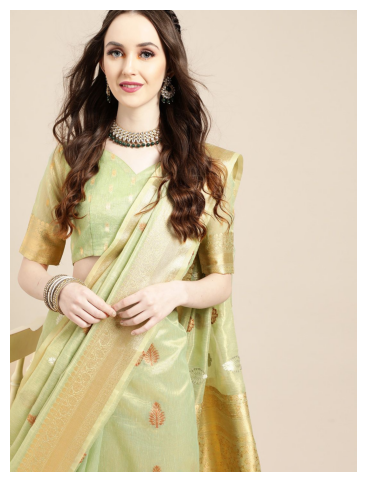

********************************************************************************


User Query : 
	 I need the outfit for goa trip. please suggest me a western clothes

 Response :
	 "Elevate your style with our stunning Gold and Black Striped Top and
Solid Dhoti Pants set! Made from pure cotton, this chic ensemble
features a mandarin collar, three-quarter sleeves, and a zip closure
for a perfect fit. Hand wash for the first time and enjoy easy machine
wash care thereafter. Embrace comfort and sophistication with this
must-have outfit!"


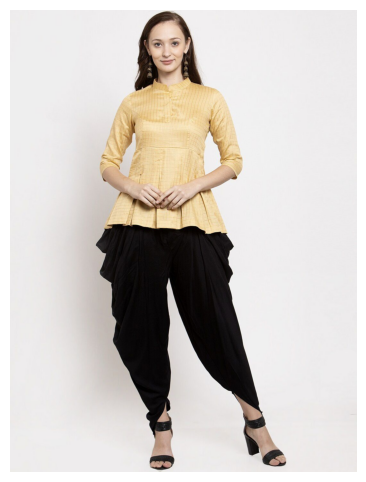

********************************************************************************


User Query : 
	 Give me white color shorts with blue top

 Response :
	 "Elevate your summer style with our chic co-ord set featuring a white
and blue dyed top with shoulder straps and sleeveless design, paired
with matching drawstring shorts. Made from a comfortable blend of 65%
polyester and 35% cotton, this set is perfect for all your sunny day
adventures. Hand wash for easy care. Get the look that the model
(height 5'8) is rocking in size S!"


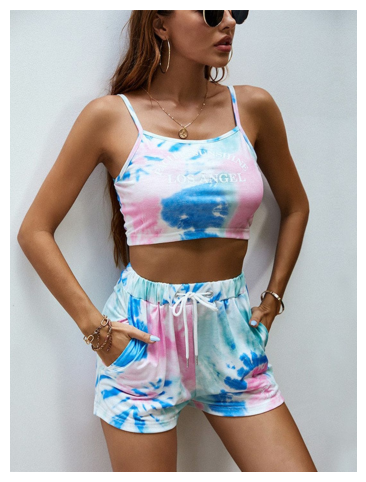

********************************************************************************


User Query : 
	 give me the outfit for winter wear

 Response :
	 Elevate your winter style with our trendsetting smart jacket! Crafted
with a hooded collar and long sleeves, this gorgeous red piece is both
functional and fashionable. Stand out from the crowd and stay warm in
style. #WinterEssential #FashionForward #StayWarmStayStylish


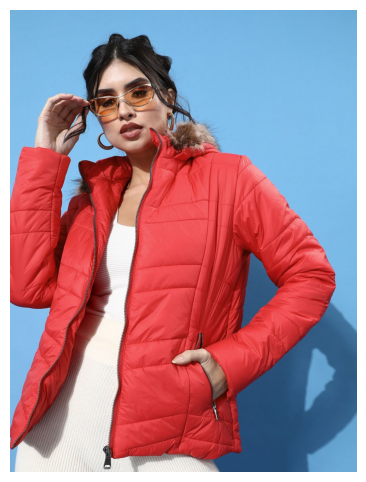

********************************************************************************


In [12]:
while True:
    query = input("Enter the query")
    if query.lower() == 'exit':
        break
    response = query_engine.query(query)
    marketing_statement = market_the_product(response)
    img = extract_image_from_url(response)
    display_output(query, marketing_statement, img)
    